# Masking Notebook
<hr>
# Notebook Summary

* LANDSAT 7 and LANDSAT 8 are used to detect changes in plant life over time.
* Very basic xarray manipulations are performed.
* The data is cleaned of clouds and scanlines.

<hr>
# Algorithmic process  

* [Import dependencies and connect to the datacube](#import)
* [Choose platform and product](#plat_prod)
* [Get the maximum extents of the datacube](#extents)
* [Define extents you require that fall within the maximum extents](#define_extents) (selecting too much can make the acquisition process slow)
* [Understand filtering of cloud data and scan lines](#filter)
* [Retrieve the data from the datacube](#retrieve_data)
* [Obtain the clean mask](#obtain_clean_mask)
* [Filter out clouds, scan lines, and invalid data](#clean_mask)

## <a id="import">Import Dependencies and Connect to the Data Cube</a>

In [1]:
%matplotlib inline
# Ignore warnings (from NDVI)
import warnings
warnings.simplefilter('ignore')

# Import the datacube and the API
import datacube
from utils.data_cube_utilities.data_access_api import DataAccessApi
from utils.data_cube_utilities.dc_display_map import display_map
from dc_notebook_utilities import generate_metadata_report
from utils.data_cube_utilities.clean_mask import landsat_clean_mask_invalid
import numpy as np
import matplotlib.pyplot as plt

# Create an instance of the datacube and API
dc = datacube.Datacube(config="/home/localuser/.datacube.conf")
api = DataAccessApi(config="/home/localuser/.datacube.conf")

## <a id="plat_prod">Choose Platform and Product</a>

In [2]:
# Get available products
products_info = dc.list_products()

# List LANDSAT 7 products
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
8,LANDSAT_7,ls7_collections_sr_scene
67,LANDSAT_7,ls7_collections_sr_scene_lean
78,LANDSAT_7,ls7_collections_sr_scene_mini
19,LANDSAT_7,ls7_ledaps_amazon_river
20,LANDSAT_7,ls7_ledaps_bangladesh
35,LANDSAT_7,ls7_ledaps_bangladesh_bari
87,LANDSAT_7,ls7_ledaps_caqueta
21,LANDSAT_7,ls7_ledaps_colombia
22,LANDSAT_7,ls7_ledaps_ghana


In [3]:
# List LANDSAT 8 products
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,
9,LANDSAT_8,ls8_collections_sr_scene
69,LANDSAT_8,ls8_collections_sr_scene_lean
86,LANDSAT_8,ls8_lasrc_caqueta
73,LANDSAT_8,ls8_lasrc_honduras
32,LANDSAT_8,ls8_lasrc_lake_chad_full
33,LANDSAT_8,ls8_lasrc_meta_river
70,LANDSAT_8,ls8_lasrc_samoa
83,LANDSAT_8,ls8_lasrc_swiss_mini
77,LANDSAT_8,ls8_lasrc_switzerland


In [4]:
# These are the platforms (satellites) and products (datacube sets) 
# used for this demonstration. Only select one LANDSAT 7 product, 
# one LANDSAT 8 product, or one of both. The products must have similar areas.
platforms = ["LANDSAT_7", "LANDSAT_8"] # Must be list            
products = ["ls7_ledaps_vietnam", "ls8_lasrc_vietnam"] # Must be list   

The magnitudes of the different wavelengths of light can be quanitized and stored on a per pixel basis.  <font color=green>NDVI</font> only requires the use of <font color=red>NIR</font> and <font color=red>RED</font> light but there are many more wavelengths and some additional measures available.  One such additional measure is called <font color=darkblue>pixel_qa</font>.  This is a measure of the quality of the pixel for analysis. A breakdown of the values stored in <font color=darkblue>pixel_qa</font> are beyond the scope of this notebook but we encourage you to check our github for more information on the meaning behind the values stored within.
![](diagrams/rainy_demo/ls7_xarray.png) 

## <a id="extents">Get the Extents of the Cube</a>

In [5]:
min_max_dates = np.empty((len(platforms), 2), dtype=object)
min_max_lat = np.empty((len(platforms), 2))
min_max_lon = np.empty((len(platforms), 2))
for i, (platform, product) in enumerate(zip(platforms, products)):
    # Get the extents of the cube
    descriptor = api.get_query_metadata(platform=platform, product=product)

    # Save extents
    min_max_dates[i] = descriptor['time_extents']#(min_date, max_date)
    min_max_lat[i] = descriptor['lat_extents']#(min_lat, max_lat)
    min_max_lon[i] = descriptor['lon_extents']#(min_lon, max_lon)
    
# Determine minimum and maximum longitudes that bound a common area among products
min_lon = np.max(min_max_lon[:,0]) # The greatest minimum longitude among products
max_lon = np.min(min_max_lon[:,1]) # The smallest maximum longitude among products
min_lat = np.max(min_max_lat[:,0])
max_lat = np.min(min_max_lat[:,1])
full_lon = (min_lon, max_lon)
full_lat = (min_lat, max_lat)
# Display the total shared area available for these datacube products.
display_map(latitude = full_lat,longitude = full_lon)

## <a id="define_extents">Define the Extents of the Analysis</a>

**Specify start and end dates in the same order as platforms and products**

In [6]:
# Select all data available to each product.
start_dates = min_max_dates[:,0]
end_dates = min_max_dates[:,1]

**Specify an area and a point within it to analyze**

In [7]:
# Specify latitude and longitude bounds of an interesting area within the full extents
# shown in the metadata report above (reduce area for faster processing times).
min_lon_small_area = 107.15#106.8
max_lon_small_area = 107.25#106.92
min_lat_small_area = 10.95#11.10
max_lat_small_area = 11.00#11.39

**Visualize the selected area**

In [8]:
# Display the subset of the region to be analyzed.
lon_small = (min_lon_small_area, max_lon_small_area)
lat_small = (min_lat_small_area, max_lat_small_area)
display_map(lat_small, lon_small)

## <a id="retrieve_data">Retrieve the data from the datacube</a>

In [9]:
measurements = ['red', 'green', 'blue', 'swir1', 'swir2', 'nir', 'pixel_qa']
datasets_in = {}
for i, (product,platform) in enumerate(zip(products, platforms)):
    start_date = start_dates[i]
    end_date = end_dates[i]
    # Query the Data Cube
    dataset_in = dc.load(lat = lat_small,
                         lon = lon_small,
                         platform = platform,
                         time = (start_date, end_date),
                         product = product,
                         measurements = measurements)
    if len(dataset_in.dims) > 0: # Sometimes data is not returned.
        datasets_in[platform] = dataset_in

## <a id="obtain_clean_mask">Obtain the clean masks</a>

In [10]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
# Get the clean mask for the LANDSAT satellite platform
clean_masks = {}
for platform in datasets_in.keys():
    clean_masks[platform] = landsat_qa_clean_mask(datasets_in[platform], platform)

## <a id="clean_mask">Filter out clouds, scan lines, and invalid data</a>

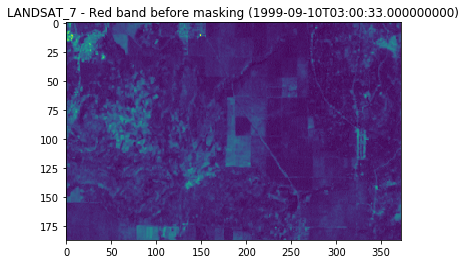

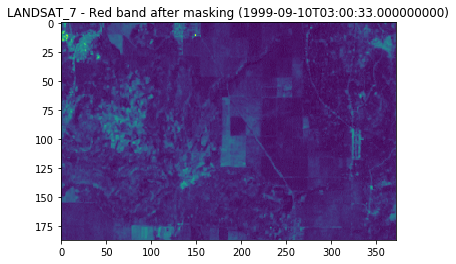

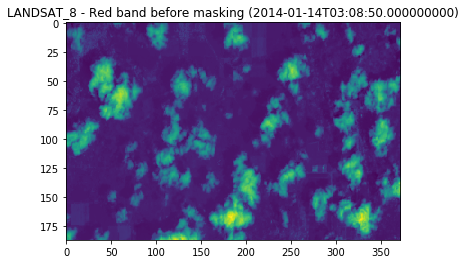

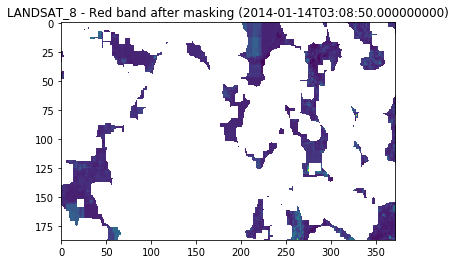

In [11]:
cleaned_datasets = {}
time_ind = 16 # Select a time to show.
for platform in datasets_in.keys():
    dataset_in = datasets_in[platform]
    clean_mask = clean_masks[platform]
    # Remove clouds.
    cleaned_datasets[platform] = dataset_in.where(clean_mask)
    # Remove data that is ouside the accepted range of LANDSAT 7 and 8.
    cleaned_datasets[platform] = landsat_clean_mask_invalid(cleaned_datasets[platform])
    # Show before masking
    plt.imshow(dataset_in.isel(time=time_ind).red, aspect='auto')
    plt.title(platform + " - Red band before masking ({})".format(str(dataset_in.time.values[0])))
    plt.show()
    # Show after masking
    plt.imshow(cleaned_datasets[platform].isel(time=time_ind).red, aspect='auto')
    plt.title(platform + " - Red band after masking ({})".format(str(dataset_in.time.values[0])))
    plt.show()